# About this Notebook:
This notebook was created in March 2021 by Pat Hawbecker (hawbecke(at)ucar(dot)edu) to provide insight into Python's Welch function and the capabilities of the new `calc_spectra` function in `mmctools`. Examples are given for the different types of data that are supported by the `calc_spectra` function and the different capabilities such as windowing, looping over dimensions, and plotting.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mmctools.helper_functions import power_spectral_density
import glob
import xarray as xr
import scipy.signal.windows as scipy_windows
from scipy.signal import welch
from IPython.display import display, Markdown, Latex

In [4]:
def psd_stull(y,dx):
    fft_y = np.fft.fft(y)
    f = np.fft.fftfreq(len(fft_y),d=dx) # Frequency info
    psd = 2.0*(fft_y.real**2 + fft_y.imag**2) # 2*(real^2 + imag^2)
    halfway = int(len(psd)/2) # Get only first half of data
    psd = psd[1:halfway]
    f = f[1:halfway]
    return(psd,f)

# Unpacking Python's Welch function:

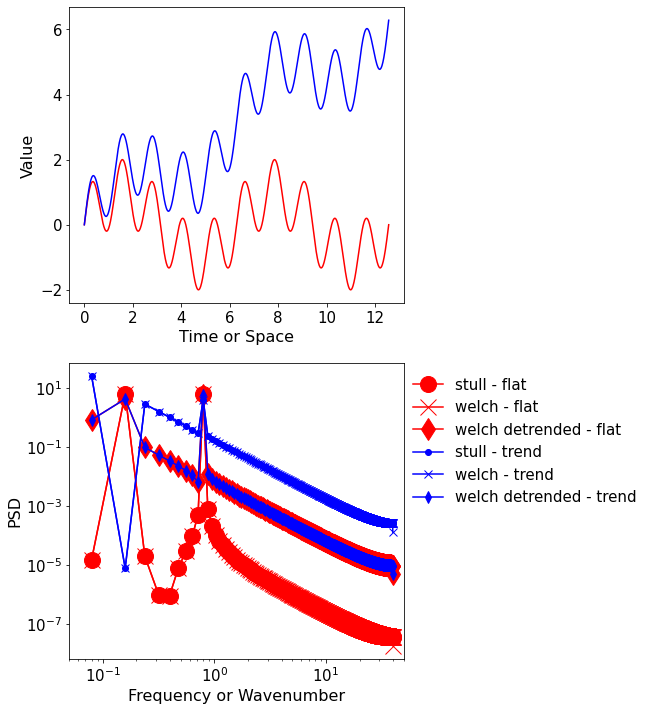

In [5]:
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(6,12))

# Create X
x = np.linspace(0,4,1000)*np.pi
dx = x[1]-x[0]
ms = 8 # marker size

# Create Y - flat / no trend
y1 = np.sin(x) + np.sin(x*5)
line_color = 'red'

# Stull PSD
psd1,f = psd_stull(y1,dx)
# Welch method multiplies by dX/N; X = time or grid spacing, N = len(signal)
psd1 = (dx/len(x))*psd1

# To use power_spectral_density, we need a dataframe:
y1_df   = pd.DataFrame(data={'y':y1,'x':x}).set_index('x')

# Test Welch with no detrending:
welch1  = power_spectral_density(y1_df,window_size=len(y1),window_type=np.ones(len(y1)),detrend=None)
welch1  = welch1.drop(0.0)

# Test Welch with detrending:
welch1d = power_spectral_density(y1_df,window_size=len(y1),window_type=np.ones(len(y1)),detrend='linear')
welch1d = welch1d.drop(0.0)
# Plots
ax[0].plot(x,y1,c=line_color)
ax[1].loglog(f,psd1,marker='o',c=line_color,label='stull - flat',markersize=ms*2)
ax[1].loglog(welch1.index,welch1,marker='x',c=line_color,label='welch - flat',markersize=ms*2)
ax[1].loglog(welch1d.index,welch1d,marker='d',c=line_color,label='welch detrended - flat',markersize=ms*2)

# Create Y - Linear increase / trend
y2 = np.sin(x) + np.sin(x*5) + x*0.5
line_color = 'blue'
# Stull PSD
psd2,f = psd_stull(y2,dx)
# Welch method multiplies by dX/N; X = time or grid spacing, N = len(signal)
psd2 = (dx/len(x))*psd2

# To use power_spectral_density, we need a dataframe:
y2_df = pd.DataFrame(data={'y':y2,'x':x}).set_index('x')
# Test Welch with no detrending:
welch2 = power_spectral_density(y2_df,window_size=len(y2),window_type=np.ones(len(y2)),detrend=None)
welch2 = welch2.drop(0.0)
# Test Welch with detrending:
welch2d = power_spectral_density(y2_df,window_size=len(y2),window_type=np.ones(len(y2)),detrend='linear')
welch2d = welch2d.drop(0.0)
# Plots
ax[0].plot(x,y2,c=line_color)
ax[1].loglog(f,psd2,marker='o',c=line_color,label='stull - trend')
ax[1].loglog(welch2.index,welch2,marker='x',c=line_color,markersize=ms,label='welch - trend')
ax[1].loglog(welch2d.index,welch2d,marker='d',c=line_color,markersize=ms,label='welch detrended - trend')

ax[0].tick_params(labelsize=15)
ax[0].set_xlabel('Time or Space',size=16)
ax[0].set_ylabel('Value',size=16)
ax[1].legend(loc=(1.01,0.5),fontsize=15,frameon=False)
ax[1].tick_params(labelsize=15)
ax[1].set_xlabel('Frequency or Wavenumber',size=16)
ax[1].set_ylabel('PSD',size=16)
ax[1].set_xlim(5e-2,5e1)
plt.show()

# INTEGRATE AND COMPARE TO VARIANCE

# Notes:
- Stull (circles) and Welch (Xs; no detrending) produce same output for each case
- Welch detrended for both cases produces same result (removes linear increase)
- Stull is very noisey if the signal is not periodic (blue circle)
- Welch with detrending is noisier when the signal is periodic (red diamond vs red X), but produces the same result for non-periodic due to _detrending_
- The main difference between Stull and Welch is the factor of dx/N; N = len(series)

# New Spectra Code:

In [6]:
from mmctools.helper_functions import calc_spectra

In [7]:
display(Markdown(calc_spectra.__doc__))


    Calculate spectra using the Welch function. This code uses the 
    power_spectral_density function from helper_functions.py. This function
    accepts either xarray dataset or dataArray, or pandas dataframe. Dimensions
    must be 4 or less (time, x, y, z). Returns a xarray dataset with the PSD of
    the variable (f(average_dim, level, frequency/wavelength)) and the frequency 
    or wavelength variables. Averages of the PSD over time or space can easily
    be done with xarray.Dataset.mean(dim='[dimension_name]').
    
    Parameters
    ==========
    data : xr.Dataset, xr.DataArray, or pd.dataframe
        The data that spectra should be calculated over
    var_oi : str
        Variable of interest - what variable should PSD be computed from.
    spectra_dim : str
        Name of the dimension that the variable spans for spectra to be 
        computed. E.g., if you want time spectra, this should be something like
        'time' or 'datetime', if you want spatial spectra, this should be 'x' or 
        'y' (or for WRF, 'south_north' / 'west_east')
    average_dim : str
        Which dimension should be looped over for averaging. Name should be
        similar to what is described in spectra_dim
    level_dim : str (optional)
        If you have a third dimension that you want to loop over, specify the
        dimension name here. E.g., if you want to calculate PSD at several
        heights, level_dim = 'height_dim'
    level : list, array, int (optional)
        If there is a level_dim, what levels should be looped over. Default is 
        the length of level_dim.
    window : 'hamming' or specific window (optional)
        What window should be used for the PSD calculation? If None, no window
        is used in the Welch function (window is all 1's).
    number_of_windows : int (optional)
        Number of windows - determines window length as signal length / int
    window_length : int or str (optional)
        Alternative to number_of_windows, you can directly specify the length
        of the windows as an integer or as a string to be converted to a 
        time_delta. This will overwrite number_of_windows. If using time_delta,
        the window_length cannot be shorter than the data frequency.
    overlap_percent : int (optional)
        Percentage of data overlap with respect to window length.
    detrend : str (optional)
        Should the data be detrended (constant, linear, etc.). See Welch 
        function for more details.
    tstart : datetime (optional)
        If calculating the spectra over only a portion of the data, when will
        the series start (only available for timeseries at the moment).
    interval : str (optional)
        If calculating the spectra over only a portion of the data, how long
        of a segment is considered (only available for timeseries at the 
        moment).
        
        
    Example Call
    ============
    
    psd = calc_spectra(data,                       # data read in with xarray 
                       var_oi='W',                # PSD of 'W' to be computed
                       spectra_dim='west_east',     # Take the west-east line
                       average_dim='south_north',  # Average over north/south
                       level_dim='bottom_top_stag', # Compute over each level
                       level=None)    # level defaults to all levels in array
    
    

# Get Test Data
### Model Spatial Data (1 time)

In [8]:
wrf_data_dir = '/Users/hawbecke/Research/BLRP/WRF/'
wrf_data_files = sorted(glob.glob('{}test_data.nc'.format(wrf_data_dir)))

wrf_data = xr.open_dataset(wrf_data_files[0])

wrf_data = wrf_data.drop('T')

wrf_data = wrf_data.sel(bottom_top_stag=slice(0,3),
                         south_north=slice(200,220))
# Make west_east a distance:
wrf_data['west_east'] = wrf_data.west_east.data*20.0


### Obs multiple locations:

In [9]:
obs_f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/BUOY/'
obs_f_dir = '/Users/hawbecke/Research/Chesapeake/Data/Obs/Buoy/'
obs_type = 'combined' # combined or CBIBS or NDBC
#obs_dir = '{}{}/'.format(obs_f_dir,obs_type)
buoy_f = '{}{}_buoy_data_res_2019.nc'.format(obs_f_dir,obs_type)
obs_ds = xr.open_dataset(buoy_f)

buoy_loc_dict = {}
for buoyn in obs_ds.station.data:
    buoy_loc_dict[buoyn] = {'lat':float(obs_ds.sel(station=buoyn).lat.data),
                     'lon':float(obs_ds.sel(station=buoyn).lon.data)}

buoy_list = list(buoy_loc_dict.keys())

buoy_loc_dict['JTN']['lat'] = 37.21137
buoy_loc_dict['JTN']['lon'] = -76.78677

bad_buoys = ['PMC','GRF','SRP','CAM','SLM','WDC']

for bad_buoy in bad_buoys:
    buoy_list.remove(bad_buoy)


if 'FLN' in obs_ds.station.data:
    temp_obs = obs_ds.temp.copy()
    obs_ds = obs_ds.drop_vars('temp')

    fln = temp_obs.sel(station='FLN')
    t_s = obs_ds.datetime[0]
    t_e = obs_ds.datetime[-1]

    rem_starts = ['2019-07-23 18:00:00','2019-07-27 00:00:00']
    rem_ends  = ['2019-07-26 12:00:00','2019-07-27 01:45:00']

    for rem_s,rem_e in zip(rem_starts,rem_ends):
        fln.sel(datetime=slice(rem_s,rem_e)).data[:] = fln.sel(datetime=slice(rem_s,rem_e)).data[:]*np.nan

    temp_obs.sel(station='FLN').data = fln.data
    obs_ds['temp'] = temp_obs
    
# Trim to a few days (lots of NaNs...):
obs_ds = obs_ds.sel(datetime=slice('2019-07-15 00:00:00','2019-07-17 00:00:00'))

# Tests:
### WRF - Spatial (1 level), no window:

Data:
<xarray.Dataset>
Dimensions:    (Time: 1, bottom_top_stag: 3, south_north: 20, west_east: 800)
Coordinates:
    XLAT       (Time, south_north, west_east) float32 ...
    XLONG      (Time, south_north, west_east) float32 ...
  * west_east  (west_east) float64 0.0 20.0 40.0 ... 1.596e+04 1.598e+04
Dimensions without coordinates: Time, bottom_top_stag, south_north
Data variables:
    W          (Time, bottom_top_stag, south_north, west_east) float32 ...

PSD:
<xarray.Dataset>
Dimensions:          (bottom_top_stag: 1, frequency: 151, south_north: 20)
Coordinates:
  * south_north      (south_north) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * frequency        (frequency) float64 0.0 0.0001667 ... 0.02483 0.025
  * bottom_top_stag  (bottom_top_stag) int64 0
Data variables:
    W                (bottom_top_stag, south_north, frequency) float32 7.022531e-14 ... 0.0026545345



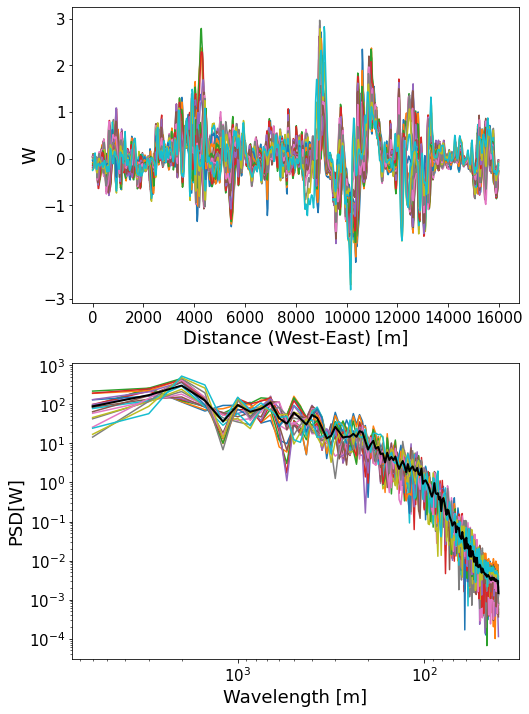

In [10]:
print('Data:')
print(wrf_data)
print()
fig,ax = plt.subplots(nrows=2,figsize=(8,12))

for jj in wrf_data.south_north:
    wrf_data.sel(south_north=jj,bottom_top_stag=0).W.plot(ax=ax[0])
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel('Distance (West-East) [m]',size=18)
ax[0].set_ylabel('W',size=18)

psd_wrf = calc_spectra(wrf_data.to_dataframe(),
                       var_oi='W',
                       spectra_dim='west_east',
                       average_dim='south_north',
                       level_dim='bottom_top_stag',
                       level=np.asarray([0]),
                       window=None,
                       window_length=300,
                       window_overlap_pct=0)

print('PSD:')
print(psd_wrf)
print()

for sn in psd_wrf.south_north:
    sn_psd = psd_wrf.sel(south_north=sn,bottom_top_stag=0).W
    if not np.any(np.isnan(sn_psd)):
        ax[1].plot(1/sn_psd.frequency,sn_psd)

ax[1].plot(1/psd_wrf.frequency,psd_wrf.sel(bottom_top_stag=0).mean(dim='south_north').W,
         lw=2.0,c='k')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].invert_xaxis()
ax[1].set_xlabel('Wavelength [m]',size=18)
ax[1].set_ylabel('PSD[W]',size=18)
ax[1].tick_params(labelsize=15)
plt.show()

### Spatial (1 level), hamming window:

Data:
<xarray.Dataset>
Dimensions:    (Time: 1, bottom_top_stag: 3, south_north: 20, west_east: 800)
Coordinates:
    XLAT       (Time, south_north, west_east) float32 39.681892 ... 39.681213
    XLONG      (Time, south_north, west_east) float32 -7.8277283 ... -7.635315
  * west_east  (west_east) float64 0.0 20.0 40.0 ... 1.596e+04 1.598e+04
Dimensions without coordinates: Time, bottom_top_stag, south_north
Data variables:
    W          (Time, bottom_top_stag, south_north, west_east) float32 0.062085204 ... -0.0074310796

PSD:
<xarray.Dataset>
Dimensions:          (bottom_top_stag: 1, frequency: 201, south_north: 20)
Coordinates:
  * south_north      (south_north) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * frequency        (frequency) float64 0.0 0.000125 0.00025 ... 0.02488 0.025
  * bottom_top_stag  (bottom_top_stag) int64 0
Data variables:
    W                (bottom_top_stag, south_north, frequency) float32 19.538136 ... 4.9784434e-05



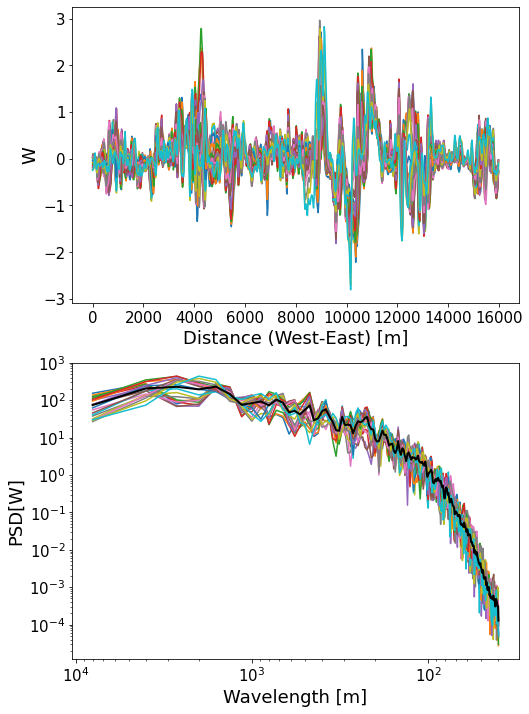

In [11]:
print('Data:')
print(wrf_data)
print()
fig,ax = plt.subplots(nrows=2,figsize=(8,12))

for jj in wrf_data.south_north:
    wrf_data.sel(south_north=jj,bottom_top_stag=0).W.plot(ax=ax[0])
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel('Distance (West-East) [m]',size=18)
ax[0].set_ylabel('W',size=18)

psd_wrf = calc_spectra(wrf_data.to_dataframe(),
                       var_oi='W',
                       spectra_dim='west_east',
                       average_dim='south_north',
                       level_dim='bottom_top_stag',
                       level=np.asarray([0]),
                       window='hamming',
                       number_of_windows=2)

print('PSD:')
print(psd_wrf)
print()

for sn in psd_wrf.south_north:
    sn_psd = psd_wrf.sel(south_north=sn,bottom_top_stag=0).W
    if not np.any(np.isnan(sn_psd)):
        ax[1].plot(1/sn_psd.frequency,sn_psd)

ax[1].plot(1/psd_wrf.frequency,psd_wrf.sel(bottom_top_stag=0).mean(dim='south_north').W,
         lw=2.0,c='k')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].invert_xaxis()
ax[1].set_xlabel('Wavelength [m]',size=18)
ax[1].set_ylabel('PSD[W]',size=18)
ax[1].tick_params(labelsize=15)
plt.show()

### Spatial (1 level), custom window:

Data:
<xarray.Dataset>
Dimensions:    (Time: 1, bottom_top_stag: 3, south_north: 20, west_east: 800)
Coordinates:
    XLAT       (Time, south_north, west_east) float32 39.681892 ... 39.681213
    XLONG      (Time, south_north, west_east) float32 -7.8277283 ... -7.635315
  * west_east  (west_east) float64 0.0 20.0 40.0 ... 1.596e+04 1.598e+04
Dimensions without coordinates: Time, bottom_top_stag, south_north
Data variables:
    W          (Time, bottom_top_stag, south_north, west_east) float32 0.062085204 ... -0.0074310796



/Users/hawbecke/Code/Python/mmctools/mmctools/helper_functions.py:1200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (window == 'hamming') or (window == 'hanning'):


PSD:
<xarray.Dataset>
Dimensions:          (bottom_top_stag: 1, frequency: 201, south_north: 20)
Coordinates:
  * south_north      (south_north) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * frequency        (frequency) float64 0.0 0.000125 0.00025 ... 0.02488 0.025
  * bottom_top_stag  (bottom_top_stag) int64 0
Data variables:
    W                (bottom_top_stag, south_north, frequency) float32 1.3793411e-13 ... 0.00021522441



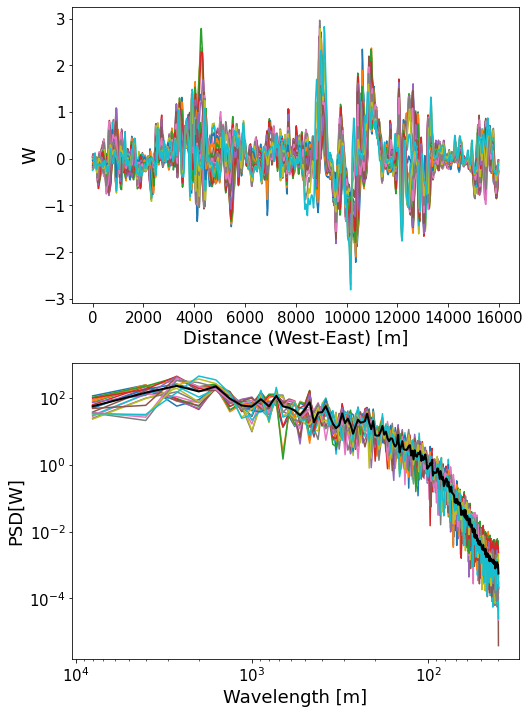

In [12]:
print('Data:')
print(wrf_data)
print()
fig,ax = plt.subplots(nrows=2,figsize=(8,12))

for jj in wrf_data.south_north:
    wrf_data.sel(south_north=jj,bottom_top_stag=0).W.plot(ax=ax[0])
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel('Distance (West-East) [m]',size=18)
ax[0].set_ylabel('W',size=18)

psd_wrf = calc_spectra(wrf_data.to_dataframe(),
                       var_oi='W',
                       spectra_dim='west_east',
                       average_dim='south_north',
                       level_dim='bottom_top_stag',
                       level=np.asarray([0]),
                       window=scipy_windows.boxcar(int(wrf_data.dims['west_east']/2)),
                       number_of_windows=2,
                       window_overlap_pct=0)

print('PSD:')
print(psd_wrf)
print()

for sn in psd_wrf.south_north:
    sn_psd = psd_wrf.sel(south_north=sn,bottom_top_stag=0).W
    if not np.any(np.isnan(sn_psd)):
        ax[1].plot(1/sn_psd.frequency,sn_psd)

ax[1].plot(1/psd_wrf.frequency,psd_wrf.sel(bottom_top_stag=0).mean(dim='south_north').W,
         lw=2.0,c='k')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].invert_xaxis()
ax[1].set_xlabel('Wavelength [m]',size=18)
ax[1].set_ylabel('PSD[W]',size=18)
ax[1].tick_params(labelsize=15)
plt.show()

### WRF - Spatial (several levels):

Data:
<xarray.Dataset>
Dimensions:    (Time: 1, bottom_top_stag: 3, south_north: 20, west_east: 800)
Coordinates:
    XLAT       (Time, south_north, west_east) float32 39.681892 ... 39.681213
    XLONG      (Time, south_north, west_east) float32 -7.8277283 ... -7.635315
  * west_east  (west_east) float64 0.0 20.0 40.0 ... 1.596e+04 1.598e+04
Dimensions without coordinates: Time, bottom_top_stag, south_north
Data variables:
    W          (Time, bottom_top_stag, south_north, west_east) float32 0.062085204 ... -0.0074310796

PSD:
<xarray.Dataset>
Dimensions:          (bottom_top_stag: 3, frequency: 401, south_north: 20)
Coordinates:
  * bottom_top_stag  (bottom_top_stag) int64 0 1 2
  * south_north      (south_north) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * frequency        (frequency) float64 0.0 6.25e-05 0.000125 ... 0.02494 0.025
Data variables:
    W                (bottom_top_stag, south_north, frequency) float32 0.8459821 ... 0.013956464



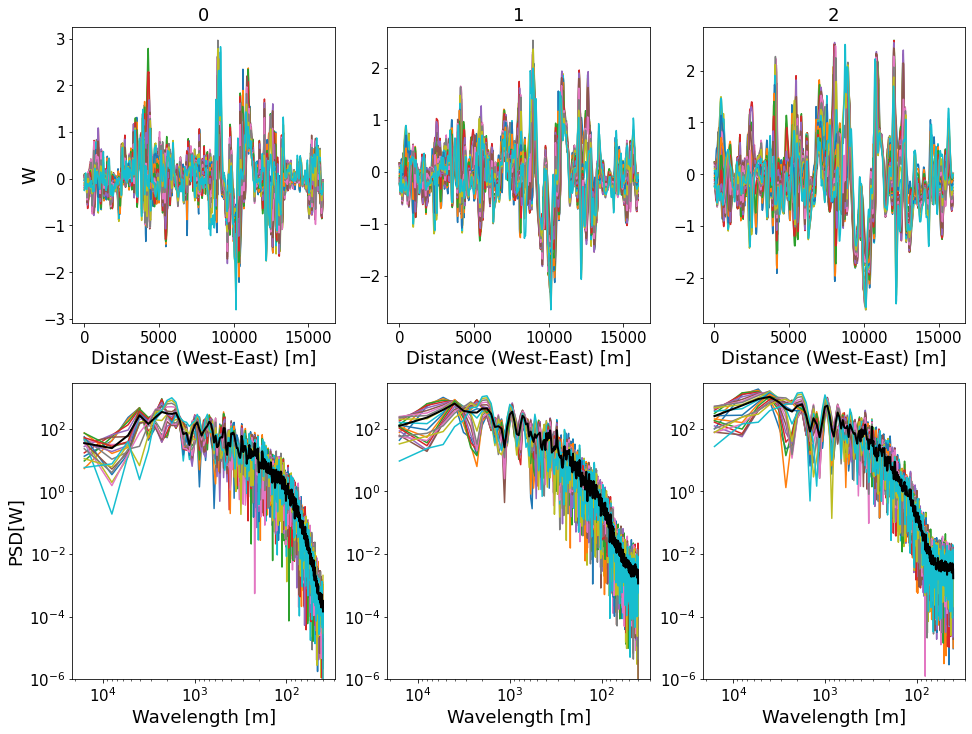

In [13]:
print('Data:')
print(wrf_data)
print()
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(16,12))

for kk,lvl in enumerate(wrf_data.bottom_top_stag):
    for jj in wrf_data.south_north:
        wrf_data.sel(south_north=jj,bottom_top_stag=lvl).W.plot(ax=ax[0,kk])
    ax[0,kk].tick_params(labelsize=15)
    ax[0,kk].set_xlabel('Distance (West-East) [m]',size=18)
    if kk == 0:
        ylbl = 'W'
    else:
        ylbl = ''
    ax[0,kk].set_ylabel(ylbl,size=18)
    ax[0,kk].set_title(lvl.data,size=18)


psd_wrf = calc_spectra(wrf_data.to_dataframe(),
                       var_oi='W',
                       spectra_dim='west_east',
                       average_dim='south_north',
                       level_dim='bottom_top_stag',
                       #level=[0,1,2], # Can also specify the levels explicitly
                       )

print('PSD:')
print(psd_wrf)
print()

for kk,lvl in enumerate(wrf_data.bottom_top_stag):
    for sn in psd_wrf.south_north:
        sn_psd = psd_wrf.sel(south_north=sn,bottom_top_stag=lvl).W
        if not np.any(np.isnan(sn_psd)):
            ax[1,kk].plot(1/sn_psd.frequency,sn_psd)

    ax[1,kk].plot(1/psd_wrf.frequency,psd_wrf.sel(bottom_top_stag=lvl).mean(dim='south_north').W,
             lw=2.0,c='k')
    if kk == 0:
        ylbl = 'PSD[W]'
    else:
        ylbl = ''
    ax[1,kk].set_xscale('log')
    ax[1,kk].set_yscale('log')
    ax[1,kk].set_ylim(1e-6,3e3)
    ax[1,kk].invert_xaxis()
    ax[1,kk].set_xlabel('Wavelength [m]',size=18)
    ax[1,kk].set_ylabel(ylbl,size=18)
    ax[1,kk].tick_params(labelsize=15)
plt.show()

### Test with heights being actual values (not indices):

Data:
<xarray.Dataset>
Dimensions:    (Time: 1, south_north: 20, west_east: 800, z: 3)
Coordinates:
    XLAT       (Time, south_north, west_east) float32 39.681892 ... 39.681213
    XLONG      (Time, south_north, west_east) float32 -7.8277283 ... -7.635315
  * west_east  (west_east) float64 0.0 20.0 40.0 ... 1.596e+04 1.598e+04
  * z          (z) float64 10.0 100.0 1e+03
Dimensions without coordinates: Time, south_north
Data variables:
    W          (Time, z, south_north, west_east) float32 0.062085204 ... -0.0074310796

PSD:
<xarray.Dataset>
Dimensions:      (frequency: 401, south_north: 20, z: 2)
Coordinates:
  * z            (z) float64 10.0 1e+03
  * south_north  (south_north) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
  * frequency    (frequency) float64 0.0 6.25e-05 0.000125 ... 0.02494 0.025
Data variables:
    W            (z, south_north, frequency) float32 0.8459821 ... 0.013956464



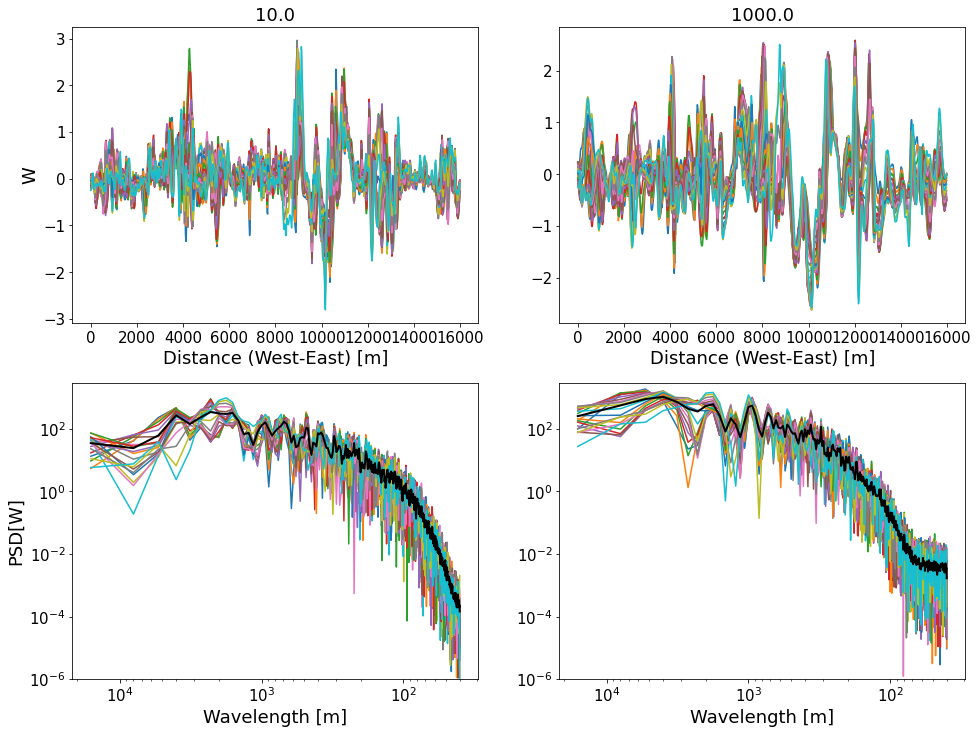

In [14]:
test_heights = wrf_data.copy()
test_heights = test_heights.rename_dims({'bottom_top_stag':'z'})
test_heights['z'] = xr.DataArray([10.0,100.0,1000.0],dims=['z'])
test_heights = test_heights.assign_coords({'z':test_heights.z})

# Pick a subset of the levels:
levels_of_interest = [10.0,1000.0]

print('Data:')
print(test_heights)
print()
fig,ax = plt.subplots(nrows=2,ncols=len(levels_of_interest),figsize=(16,12))

for kk,lvl in enumerate(levels_of_interest):
    for jj in test_heights.south_north:
        test_heights.sel(south_north=jj,z=lvl).W.plot(ax=ax[0,kk])
    ax[0,kk].tick_params(labelsize=15)
    ax[0,kk].set_xlabel('Distance (West-East) [m]',size=18)
    if kk == 0:
        ylbl = 'W'
    else:
        ylbl = ''
    ax[0,kk].set_ylabel(ylbl,size=18)
    ax[0,kk].set_title(lvl,size=18)

psd_lvl = calc_spectra(test_heights,
                       var_oi='W',
                       spectra_dim='west_east',
                       average_dim='south_north',
                       level_dim='z',
                       #level=levels_of_interest)
                       level=[11.0,999.0])

print('PSD:')
print(psd_lvl)
print()

for kk,lvl in enumerate(levels_of_interest):
    for sn in psd_lvl.south_north:
        sn_psd = psd_lvl.sel(south_north=sn).sel(z=lvl,method='nearest').W
        if not np.any(np.isnan(sn_psd)):
            ax[1,kk].plot(1/sn_psd.frequency,sn_psd)

    ax[1,kk].plot(1/psd_lvl.frequency,psd_lvl.sel(z=lvl,method='nearest').mean(dim='south_north').W,
             lw=2.0,c='k')
    if kk == 0:
        ylbl = 'PSD[W]'
    else:
        ylbl = ''
    ax[1,kk].set_xscale('log')
    ax[1,kk].set_yscale('log')
    ax[1,kk].set_ylim(1e-6,3e3)
    ax[1,kk].invert_xaxis()
    ax[1,kk].set_xlabel('Wavelength [m]',size=18)
    ax[1,kk].set_ylabel(ylbl,size=18)
    ax[1,kk].tick_params(labelsize=15)
plt.show()

### Obs - Temporal:

Data:
<xarray.Dataset>
Dimensions:   (datetime: 49, station: 19)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2019-07-15 ... 2019-07-17
  * station   (station) object 'ANN' 'BIS' 'CAM' 'DEB' ... 'WDC' 'YKP' 'YKS'
Data variables:
    sst       (station, datetime) float64 ...
    dwpt      (station, datetime) float64 ...
    wspd      (station, datetime) float64 ...
    wdir      (station, datetime) float64 ...
    pres      (station, datetime) float64 ...
    lat       (station) float64 ...
    lon       (station) float64 ...
    dpth      (station, datetime) float64 ...
    rh        (station, datetime) float64 ...
    temp      (station, datetime) float64 31.4 30.2 29.5 28.5 ... 28.9 28.5 28.0

PSD:
<xarray.Dataset>
Dimensions:    (frequency: 13, station: 19)
Coordinates:
  * station    (station) object 'ANN' 'BIS' 'CAM' 'DEB' ... 'WDC' 'YKP' 'YKS'
  * frequency  (frequency) float64 0.0 1.157e-05 ... 0.0001273 0.0001389
Data variables:
    wspd       (station, frequency) float

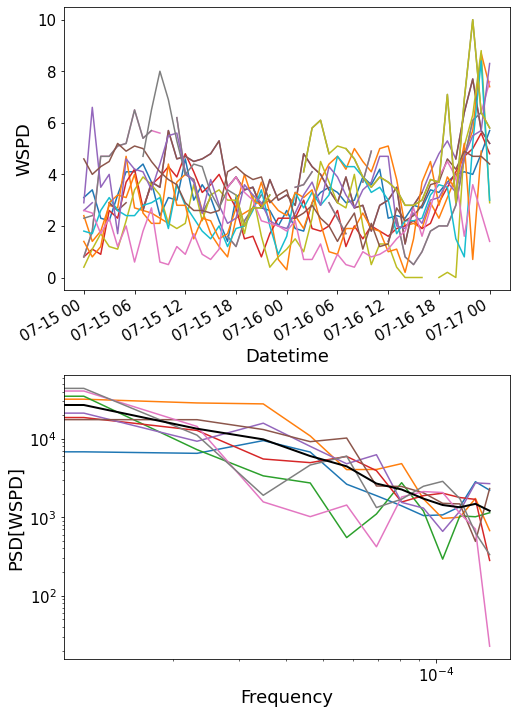

In [15]:
print('Data:')
print(obs_ds)
print()
fig,ax = plt.subplots(nrows=2,figsize=(8,12))
plt.subplots_adjust(hspace=0.3)
for stn in obs_ds.station:
    obs_ds.sel(station=stn).wspd.plot(ax=ax[0])
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel('Datetime',size=18)
ax[0].set_ylabel('WSPD',size=18)
ax[0].set_title('')

psd_obs = calc_spectra(obs_ds,
                       var_oi='wspd',
                       spectra_dim='datetime',
                       average_dim='station',
                       window_length='24h',
                       )

print('PSD:')
print(psd_obs)
print()
for stn in psd_obs.station:
    stn_psd = psd_obs.sel(station=stn).wspd
    if not np.any(np.isnan(stn_psd)):
        stn_psd.plot(ax=ax[1])
ax[1].plot(psd_obs.frequency,psd_obs.mean(dim='station').wspd,
           lw=2.0,c='k')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Frequency',size=18)
ax[1].set_ylabel('PSD[WSPD]',size=18)
ax[1].tick_params(labelsize=15)
ax[1].set_title('')
plt.show()

# Using 1-D data:

Data:
                      y
x                      
0.000000   0.000000e+00
0.012579   7.543191e-02
0.025158   1.506133e-01
0.037737   2.252945e-01
0.050316   2.992281e-01
...                 ...
12.516055 -2.992281e-01
12.528634 -2.252945e-01
12.541213 -1.506133e-01
12.553792 -7.543191e-02
12.566371 -2.939152e-15

[1000 rows x 1 columns]

PSD:
<xarray.Dataset>
Dimensions:    (frequency: 501)
Coordinates:
  * frequency  (frequency) float64 0.0 0.0795 0.159 0.2385 ... 39.59 39.67 39.75
Data variables:
    y          (frequency) float64 4.217e-32 1.478e-05 ... 3.585e-08 1.792e-08



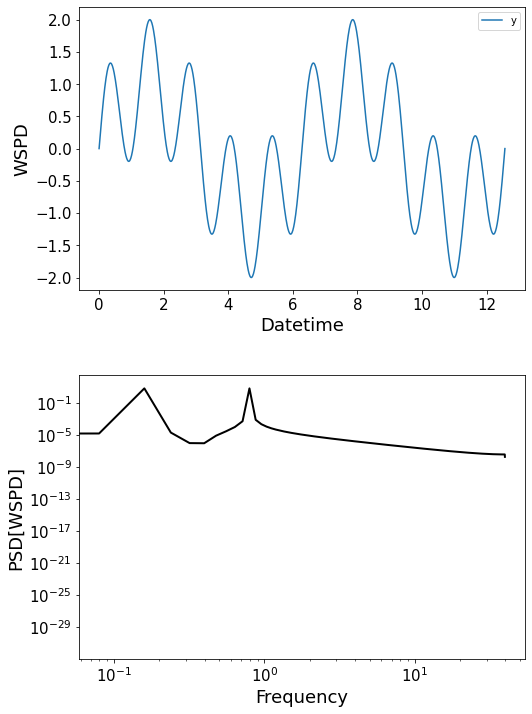

In [16]:
print('Data:')
print(y1_df)
print()
fig,ax = plt.subplots(nrows=2,figsize=(8,12))
plt.subplots_adjust(hspace=0.3)
y1_df.plot(ax=ax[0])
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel('Datetime',size=18)
ax[0].set_ylabel('WSPD',size=18)
ax[0].set_title('')

psd_1d = calc_spectra(y1_df,
                      var_oi='y',
                      spectra_dim='x',
                      average_dim=None,
                      window=None)

print('PSD:')
print(psd_1d)
print()

ax[1].plot(psd_1d.frequency,psd_1d.y,
           lw=2.0,c='k')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Frequency',size=18)
ax[1].set_ylabel('PSD[WSPD]',size=18)
ax[1].tick_params(labelsize=15)
ax[1].set_title('')
plt.show()